# Classification of Associated Place Reinstatement

#### fMRI preprocessing:

```
##############################################
# Register timeseries for MVPA analyses
##############################################

sub_list=subjects.txt
exp=mvpa_raw
 
run_fmri.py -s $sub_list -e $exp -w preproc reg -t -regspace epi -unsmoothed
```

In [5]:
%matplotlib inline

In [6]:
import glob
import os.path as op
import os as os
import nibabel as nib
import pandas as pd
import numpy as np
import scipy as sp

from nilearn.masking import compute_epi_mask

import matplotlib.pyplot as plt
import matplotlib as mpl

# Nilearn for neuro-imaging-specific machine learning
from nilearn.input_data import NiftiMasker
from nilearn import image

# Nibabel for general neuro-imaging tools
import nibabel

# Scikit-learn for machine learning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
from sklearn import preprocessing

# Plotting
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
sns.set(context="poster", style="ticks", font="Arial")


In [7]:
palette = {'logreg': 'mediumseagreen',
           'chance': 'darkgray',
           'f1 score': 'teal'}

### Define some functions for classification 

In [8]:
from ap_classify import *

### Define function to train on localizer, calculate probabilities w/test data

## Set up directory & file information

In [15]:
smoothing = 'unsmoothed'
regspace = 'epi'
loc_design = 'localizer_cond_mvpa.csv'
mem_design = 'AP_memory_itemhits_byrep.csv' 
# mem_design = 'AP_memory_itemhits.csv' # equalize trial counts
smoothing_fwhm = 0
standardize = True
multi_class_alg = 'ovr'
tr = float(2)
tr_shift = 4.5 #4.5 seconds post-stim onset
tr_shift_test_list = [0, 2, 4, 6, 8, 10, 12] # seconds to shift onset forward by

basedir = '/Volumes/group/awagner/sgagnon/AP'
analydir = op.join(basedir, 'analysis/mvpa_raw')
subjfile = op.join(analydir, 'notebooks/subj_info.csv')
subj_info = pd.read_csv(subjfile)

# Filepath templates
tsfile = op.join(analydir, "{subid}", 'reg', regspace, 
                 smoothing, "run_{run_id}", 'timeseries_xfm.nii.gz')
func_maskfile = op.join(analydir, "{subid}", 'reg', regspace, 
                        smoothing, "run_{run_id}", 'functional_mask_xfm.nii.gz')
maskfile = op.join(basedir, 'data', "{subid}", 'masks', 
                   "{mask_name}.nii.gz")
# meanfile = op.join(analydir, "{subid}", 'reg', regspace, 
#                    smoothing, "run_{run_id}", 'mean_func_xfm.nii.gz')
meanfile = op.join(analydir, "{subid}", 'preproc',
                   "run_{run_id}", 'mean_func.nii.gz')
loc_onsetfile = op.join(basedir, 'data', "{subid}", 'design', loc_design)
mem_onsetfile = op.join(basedir, 'data', "{subid}", 'design', mem_design)


# Output templates
outnifti = op.join(analydir, "{subid}", 'importance_maps')
outtrials = op.join(analydir, "{subid}", 'trial_estimates', 
'{subid}_{output}_{time}s_trial_{multi_class_alg}_estimates_3class_{mask}_byrep_filtartloc_scalewithinrun.csv')
# outtrials = op.join(analydir, "{subid}", 'trial_estimates', 
#                     '{subid}_{output}_{time}s_trial_{multi_class_alg}_estimates_3class_{mask}_byrep_filtartloc_equalizecounts.csv')

artifacts = op.join(analydir, '{subid}', 'preproc', 'run_{run}', 'artifacts.csv')

# Combine paths into dictionary (facilitate passing i/o of funcs)
paths = dict(tsfile=tsfile, func_maskfile=func_maskfile, 
             maskfile=maskfile, meanfile=meanfile, 
             loc_onsetfile=loc_onsetfile, mem_onsetfile=mem_onsetfile, 
             outnifti=outnifti, outtrials=outtrials, analydir=analydir, artifacts=artifacts)

## Run Classification

In [16]:
subj_info.groupby('group').count()

,subid
group,
control,22
stress,22


In [19]:
pd.read_csv(mem_onsetfile.format(subid='ap100')).condition.unique()

array(['sourcemiss_hi-4', 'CR-0', 'sourcehit-2', 'sourcehit-4', 'M-4',
       'M-2', 'FA-0', 'itemhit_lo-2', 'sourcemiss_hi-2', 'itemhit_lo-4',
       'nuisance-2', 'nuisance'], dtype=object)

In [20]:
# Initialize some stuff
mask_type = 'mask' # functional mask, or defined elsewhere
mask_name = 'bilat-parahipp_fusi_inftemp_nohipp'
# mask_name = 'bilat-fusi_inftemp_nohipp'
# mask_name = 'lh-inferiorparietal'

# Localizer and memory data info
loc_run_list = [7,8]
mem_run_list = range(1,7)

loc_cond_list = ['face', 'object', 'place']
# loc_cond_list = ['face', 'place']
mem_cond_list = ['sourcemiss_hi-4', 'CR-0', 'sourcehit-2', 'sourcehit-4', 'M-4',
                 'M-2', 'FA-0', 'itemhit_lo-2', 'sourcemiss_hi-2', 'itemhit_lo-4']

# mem_cond_list = ['sourcehit', 'CR'] # when equalizing trial counts

#### Calculate trial counts/type of stimulus:

In [11]:
condition_df = pd.DataFrame(mem_cond_list, columns=['index']) # dataframe of conditions requested

In [23]:
onsetfile = paths['mem_onsetfile']
cond_list = mem_cond_list
run_list = mem_run_list
min_counts = pd.DataFrame()

for subid in subj_info.subid:

    onsets = pd.read_csv(onsetfile.format(subid=subid)) # load in onset/event data
    onsets = onsets[onsets.condition.isin(cond_list)].reset_index() # subset for conditions
    
    for run in mem_run_list:
        run_events = onsets[onsets.run == run]
        value_counts = run_events.condition.value_counts()

        # make sure have each condition in this run
        cond_counts = pd.merge(condition_df, 
                               pd.DataFrame(value_counts).reset_index(), how='left') 
        missing_cond = np.any(cond_counts.condition.isnull()) # any missing conditions?

        if not missing_cond:
            min_count = cond_counts.condition.min()
        else:
            min_count = 0

        min_counts = min_counts.append(pd.Series({'subid': subid, 'run': run, 'min_count': min_count}), 
                                       ignore_index=True)

In [24]:
min_count = cond_counts.condition.min()

/Users/steph-backup/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


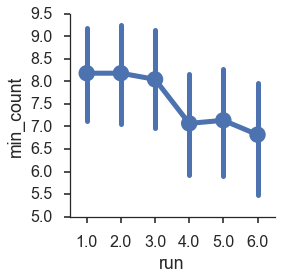

In [25]:
sns.factorplot(x='run', y='min_count', data=min_counts, units='subid')

In [26]:
min_counts.pivot_table(values='min_count', index='subid', columns='run').reset_index().describe()

run,1.0,2.0,3.0,4.0,5.0,6.0
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,8.181818,8.181818,8.045455,7.068182,7.136364,6.818182
std,3.616967,3.847516,3.803025,3.878370,4.078252,4.282320
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,5.750000,4.750000,4.000000,4.000000,3.750000
50%,7.500000,8.000000,8.000000,7.000000,7.000000,7.000000
75%,11.250000,12.000000,11.000000,10.000000,10.250000,10.000000
max,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000


#### Minimum number of trials/subject/condition:

In [27]:
min_counts.pivot_table(values='min_count', index='subid', columns='run').reset_index().sum(axis=1).min()

7.0

### Extract logits, training on localizer, testing on retrieval:

#### Equalize trial counts/condition/run:

In [9]:
df_logit = pd.DataFrame(columns=['subid', 'time', 'mask', 'mem_cond', 'class', 'logit'])

for subid in subj_info.subid:  
# for subid in subj_info.subid[35:]:
# for subid in ['ap154']:
    print subid + '-----------------------------------------------'
    
    if subid == 'ap155': # note that ap155 had to leave early on 1st day, so relevant trials are excluded from day 2 (run 6)
        mem_run_list = range(1,6)
    else:
        mem_run_list = range(1,7)
    
    df_logit = calc_acc_train_loc(df_logit, subid, paths, 
                                  mask_type, mask_name,
                                  smoothing_fwhm, standardize, tr, tr_shift,
                                  loc_cond_list, loc_run_list,
                                  mem_cond_list, mem_run_list,
                                  tr_range=True, multi_class=multi_class_alg, 
                                  output='logit', save_trials=True,
                                  timepts_save=tr_shift_test_list, 
                                  standardize_test=False, equalize_trialcounts=True)

ap100-----------------------------------------------
Loading data from run 7 ...
Removing 6 TRs with artifacts...

/Users/steph-backup/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/steph-backup/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



scaling the data...
Loading data from run 8 ...
Removing 5 TRs with artifacts...
scaling the data...
Fit localizer data...
Run list:
[1, 2, 3, 4, 5, 6]
Time sample: 0
Loading data from run 1 ...
balancing trial counts
scaling the data...
Loading data from run 2 ...
balancing trial counts
scaling the data...
Loading data from run 3 ...
balancing trial counts
scaling the data...
Loading data from run 4 ...
balancing trial counts
scaling the data...
Loading data from run 5 ...
balancing trial counts
scaling the data...
Loading data from run 6 ...
balancing trial counts
scaling the data...
Loaded in testing data...
Time sample: 2
Loading data from run 1 ...
balancing trial counts
scaling the data...
Loading data from run 2 ...
balancing trial counts
scaling the data...
Loading data from run 3 ...
balancing trial counts
scaling the data...
Loading data from run 4 ...
balancing trial counts
scaling the data...
Loading data from run 5 ...
balancing trial counts
scaling the data...
Loading da

/Users/steph-backup/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


#### Original analysis: Z-score voxels by run

In [25]:
df_logit = pd.DataFrame(columns=['subid', 'time', 'mask', 'mem_cond', 'class', 'logit'])

for subid in subj_info.subid:  
# for subid in subj_info.subid[35:]:
# for subid in ['ap154']:
    print subid + '-----------------------------------------------'
    
    if subid == 'ap155':
        mem_run_list = range(1,6)
    else:
        mem_run_list = range(1,7)
    
    df_logit = calc_acc_train_loc(df_logit, subid, paths, 
                                  mask_type, mask_name,
                                  smoothing_fwhm, standardize, tr, tr_shift,
                                  loc_cond_list, loc_run_list,
                                  mem_cond_list, mem_run_list,
                                  tr_range=True, multi_class=multi_class_alg, 
                                  output='logit', save_trials=True,
                                  timepts_save=tr_shift_test_list, 
                                  standardize_test=True, equalize_trialcounts=False)

ap100-----------------------------------------------
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
Loading data from run 8 ...
Removing 5 TRs with artifacts...
scaling the data...
Fit localizer data...
Run list:
[1, 2, 3, 4, 5, 6]
Time sample: 0
Loading data from run 1 ...
scaling the data...
Loading data from run 2 ...
scaling the data...
Loading data from run 3 ...
scaling the data...
Loading data from run 4 ...
scaling the data...
Loading data from run 5 ...
scaling the data...
Loading data from run 6 ...
scaling the data...
Loaded in testing data...
Time sample: 2
Loading data from run 1 ...
scaling the data...
Loading data from run 2 ...
scaling the data...
Loading data from run 3 ...
scaling the data...
Loading data from run 4 ...
scaling the data...
Loading data from run 5 ...
scaling the data...
Loading data from run 6 ...
scaling the data...
Loaded in testing data...
Time sample: 4
Loading data from run 1 ...
scaling the data...
Loading data 

### Recheck original VTC analysis

In [13]:
print mask_name
print multi_class_alg

bilat-parahipp_fusi_inftemp_nohipp
ovr


In [21]:
print mask_name
df_logit = pd.DataFrame(columns=['subid', 'time', 'mask', 'mem_cond', 'class', 'logit'])

for subid in subj_info.subid:  
# for subid in subj_info.subid[35:]:
# for subid in ['ap154']:
    print subid + '-----------------------------------------------'
    
    if subid == 'ap155':
        mem_run_list = range(1,6)
    else:
        mem_run_list = range(1,7)
    
    df_logit = calc_acc_train_loc(df_logit, subid, paths, 
                                  mask_type, mask_name,
                                  smoothing_fwhm, standardize, tr, tr_shift,
                                  loc_cond_list, loc_run_list,
                                  mem_cond_list, mem_run_list,
                                  tr_range=True, multi_class=multi_class_alg, 
                                  output='logit', save_trials=True,
                                  timepts_save=tr_shift_test_list, 
                                  standardize_test=True, equalize_trialcounts=False)

bilat-parahipp_fusi_inftemp_nohipp
ap100-----------------------------------------------
Loading data from run 7 ...
Removing 6 TRs with artifacts...
scaling the data...
Loading data from run 8 ...
Removing 5 TRs with artifacts...
scaling the data...
Fit localizer data...
Run list:
[1, 2, 3, 4, 5, 6]
Time sample: 0
Loading data from run 1 ...
scaling the data...
Loading data from run 2 ...
scaling the data...
Loading data from run 3 ...
scaling the data...
Loading data from run 4 ...
scaling the data...
Loading data from run 5 ...
scaling the data...
Loading data from run 6 ...
scaling the data...
Loaded in testing data...
Time sample: 2
Loading data from run 1 ...
scaling the data...
Loading data from run 2 ...
scaling the data...
Loading data from run 3 ...
scaling the data...
Loading data from run 4 ...
scaling the data...
Loading data from run 5 ...
scaling the data...
Loading data from run 6 ...
scaling the data...
Loaded in testing data...
Time sample: 4
Loading data from run 1 ..

IOError: CRC check failed 0x0 != 0x5b9451aaL

### Calculate Accuracy

Note that here, CR and FAs are not included in the trials, whereas they are for proba and logit calculations

In [24]:
ev_mapping = {'sourcehit-4': 'place',
              'itemhit_lo-4': 'place',
              'M-4': 'place',
              'sourcemiss_hi-4': 'place',
              'sourcehit-2': 'place',
              'itemhit_lo-2': 'place',
              'M-2': 'place',
              'sourcemiss_hi-2': 'place'}

In [ ]:
df_acc = pd.DataFrame(columns=['subid', 'time', 'mask', 'mem_cond', 'acc'])

mem_cond_list = ev_mapping.keys()

for subid in subj_info.subid:
# for subid in ['ap104']:
    print subid + '-----------------------------------------------'
    
    df_acc = calc_acc_train_loc(df_acc, subid, paths, 
                                mask_type, mask_name,
                                smoothing_fwhm, standardize, tr, tr_shift,
                                loc_cond_list, loc_run_list,
                                mem_cond_list, mem_run_list,
                                tr_range=True, multi_class=multi_class_alg, 
                                output='acc', save_trials=True,
                                timepts_save=tr_shift_test_list, ev_mapping=ev_mapping)

ap100-----------------------------------------------
Loading data from run 7 ...
Loading data from run 8 ...
scaling the data...
Fit localizer data...
Run list:
[1, 2, 3, 4, 5, 6]
Time sample: 0
Loading data from run 1 ...
Loading data from run 2 ...

## Save out data

#### First time running: 

In [27]:
df_logit.tail()

,class,logit,mask,mem_cond,subid,time
9067,place,-0.286509,bilat-fusi_inftemp_nohipp,itemhit_lo-4,ap174,12
9068,place,-1.172174,bilat-fusi_inftemp_nohipp,sourcehit-2,ap174,12
9069,place,-1.313748,bilat-fusi_inftemp_nohipp,sourcehit-4,ap174,12
9070,place,-2.025481,bilat-fusi_inftemp_nohipp,sourcemiss_hi-2,ap174,12
9071,place,1.795129,bilat-fusi_inftemp_nohipp,sourcemiss_hi-4,ap174,12


In [28]:
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_VTCnohipp_locfiltart_scalewithinrun.csv'
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_inferiorparietal_locfiltart_scalewithinrun.csv'
data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_VTCnoparahippnohipp_locfiltart_scalewithinrun.csv'
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_bilat-hippocampus_locfiltart_scalewithinrun.csv'
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_lh-DefaultA_IPL_locfiltart_scalewithinrun.csv'
# data_file_acc = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_acc_3class_itemhits_byrep.csv'
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_2class_itemhits_byrep_VTCnohipp_locfiltart_scalewithinrun.csv'
# data_file_logit = '/Volumes/group/awagner/sgagnon/AP/analysis/mvpa_raw/notebooks/output/group_logit_3class_itemhits_byrep_lh-DefaultC_IPL_locfiltart_scalewithinrun.csv'

df_logit.to_csv(data_file_logit)
# df_acc.to_csv(data_file_acc)/